In [5]:
from ib_insync import *

util.startLoop()
ib = IB()
ib.connect(host='172.21.224.1', port=7497, clientId=501, timeout=10)
print("Connected", ib.isConnected())

Connected True


In [12]:
ib.disconnect()

In [6]:
ib.reqMarketDataType(1)  # 1 for live, 2 for frozen, 3 for delayed, 4 for delayed frozen
print("Requested live data")

Requested live data


In [4]:
contract = Stock('AAPL', 'SMART', 'USD')
[contract] = ib.qualifyContracts(contract)

ticker = ib.reqMktData(contract, '', snapshot=True)
print(f"bid={ticker.bid} ask={ticker.ask} last={ticker.last}")


RuntimeError: This event loop is already running

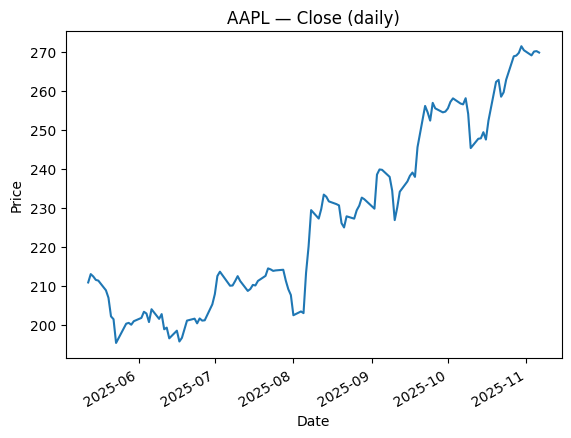

In [9]:
from ib_insync import IB, Stock, Forex, util
import pandas as pd
import matplotlib.pyplot as plt

aapl = Stock('AAPL', 'SMART', 'USD')
[aapl] = ib.qualifyContracts(aapl)

bars = ib.reqHistoricalData(
    aapl,
    endDateTime='',
    durationStr='6 M',
    barSizeSetting='1 day',
    whatToShow='TRADES',
    useRTH=True,
    formatDate=1
)

df = util.df(bars) 
df['date'] = pd.to_datetime(df['date'])   
df.set_index('date', inplace=True)
df.index = df.index.tz_localize('UTC').tz_convert('Europe/London')

ax = df['close'].plot(title='AAPL — Close (daily)')
ax.set_xlabel('Date'); ax.set_ylabel('Price')
plt.show()

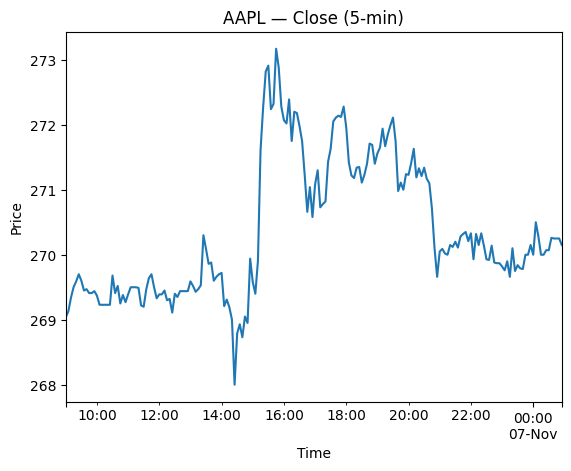

In [10]:
# Example 2: Intraday 5-min bars for AAPL (last day)
bars = await ib.reqHistoricalDataAsync(
    aapl,
    endDateTime='',
    durationStr='1 D',
    barSizeSetting='5 mins',
    whatToShow='TRADES',
    useRTH=False,    # include pre/after-hours if you want
    formatDate=1
)
df5 = util.df(bars).set_index('date')
df5.index = df5.index.tz_convert('Europe/London')
df5['close'].plot(title='AAPL — Close (5-min)')
plt.xlabel('Time'); plt.ylabel('Price'); plt.show()

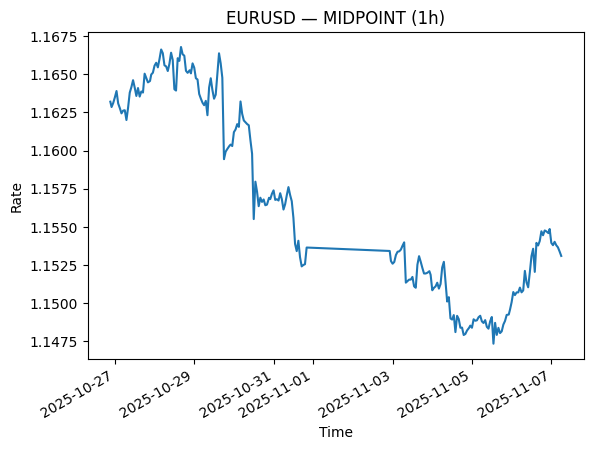

In [11]:
# Example 3: FX example (EURUSD) — use MIDPOINT for cleaner FX series
eurusd = Forex('EURUSD')
[eurusd] = await ib.qualifyContractsAsync(eurusd)

fx = await ib.reqHistoricalDataAsync(
    eurusd,
    endDateTime='',
    durationStr='2 W',
    barSizeSetting='1 hour',
    whatToShow='MIDPOINT',  # common choice for FX
    useRTH=False,
    formatDate=1
)
dfx = util.df(fx).set_index('date')
dfx.index = dfx.index.tz_convert('Europe/London')
dfx['close'].plot(title='EURUSD — MIDPOINT (1h)')
plt.xlabel('Time'); plt.ylabel('Rate'); plt.show()

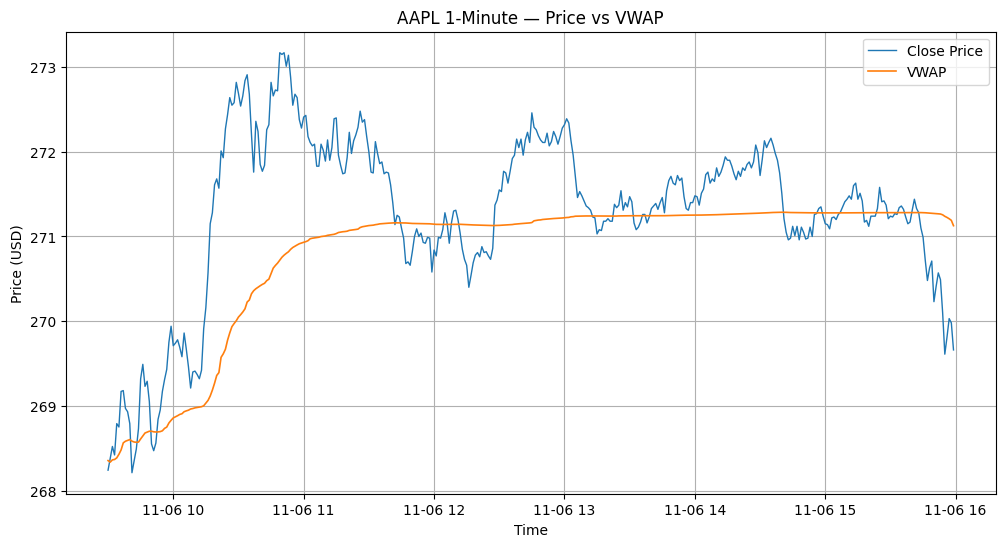

In [12]:
# Get today's 1-minute bars
bars = await ib.reqHistoricalDataAsync(
    aapl,
    endDateTime='',
    durationStr='1 D',
    barSizeSetting='1 min',
    whatToShow='TRADES',
    useRTH=True,
    formatDate=1
)

df = util.df(bars)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# VWAP formula: sum(price * volume) / sum(volume)
# Use typical price (H+L+C)/3
df['typical'] = (df['high'] + df['low'] + df['close']) / 3
df['cum_vol'] = df['volume'].cumsum()
df['cum_vp'] = (df['typical'] * df['volume']).cumsum()
df['vwap'] = df['cum_vp'] / df['cum_vol']

# Plot price and VWAP
plt.figure(figsize=(12,6))
plt.plot(df.index, df['close'], label='Close Price', linewidth=1)
plt.plot(df.index, df['vwap'], label='VWAP', linewidth=1.2)
plt.title('AAPL 1-Minute — Price vs VWAP')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()